In [12]:
from pathlib import Path
from time import strftime

PROJ_ROOT = Path().absolute()
LOG_DIR = PROJ_ROOT / "logs"
MODEL_DIR = PROJ_ROOT / "models"
MODEL_DIR, LOG_DIR


def get_run_dir(root_dir, name="run"):
    return Path(root_dir) / f"{name}-{strftime('%Y_%m_%d-%H_%M_%S')}"


get_run_dir(LOG_DIR)

PosixPath('/home/twogoodap/Coding_Playground/Machine_Learning/Hands_on_Machine_Learning/handson-machine-learning/handson_ml/chapter_11/logs/run-2023_10_23-18_33_38')

In [2]:
import matplotlib.pyplot as plt

plt.rc("font", size=10)
plt.rc("figure", autolayout=True)

In [1]:
import tensorflow as tf

tf.config.list_physical_devices("GPU")

2023-11-03 01:04:59.113736: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-03 01:04:59.137786: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-03 01:05:00.288117: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-03 01:05:00.588006:

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [6]:
import math

import matplotlib.pyplot as plt
import tensorflow.keras.backend as K
from tensorflow import keras


class ExponentialLRGrowth(keras.callbacks.Callback):
    def __init__(self, factor):
        self._factor = factor
        self.batch_losses = []
        self.learning_rates = []

    def on_epoch_begin(self, epoch, logs=None):
        self._sum_of_batch_losses = 0

    def on_batch_end(self, batch, logs=None):
        new_sum_of_batch_losses = logs["loss"] * (batch + 1)
        self.batch_losses.append(new_sum_of_batch_losses - self._sum_of_batch_losses)
        self._sum_of_batch_losses = new_sum_of_batch_losses
        lr = K.get_value(self.model.optimizer.learning_rate)
        self.learning_rates.append(lr)
        K.set_value(self.model.optimizer.learning_rate, lr * self._factor)


def find_learning_rate(model, X, y, min_lr=1e-5, max_lr=1, epochs=1, batch_size=32):
    n_steps = epochs * math.ceil(len(X) / batch_size)
    factor = (max_lr / min_lr) ** (1 / n_steps)
    init_weights = model.get_weights()
    init_lr = K.get_value(model.optimizer.learning_rate)

    exp_lr_growth = ExponentialLRGrowth(factor)
    K.set_value(model.optimizer.learning_rate, min_lr)
    model.fit(X, y, epochs=epochs, batch_size=batch_size, callbacks=[exp_lr_growth])

    model.set_weights(init_weights)
    K.set_value(model.optimizer.learning_rate, init_lr)

    return exp_lr_growth.learning_rates, exp_lr_growth.batch_losses


def plot_loss_vs_lr(lrs, losses):
    plt.plot(lrs, losses)
    plt.hlines(min(losses), min(lrs), max(lrs), "k")

    plt.axis((min(lrs), max(lrs), 0, losses[0] + min(losses)))
    plt.grid(True)
    plt.gca().set_xscale("log")
    plt.gca().set_xlabel("Learning Rate")
    plt.gca().set_ylabel("Training Loss")

In [7]:
import tensorflow.keras.backend as K
from tensorflow import keras


class OneCycleScheduler(keras.callbacks.Callback):
    def __init__(
        self, n_iters, max_lr=1e-3, min_lr=None, last_iters=None, last_lr=None
    ):
        self._n_iters = n_iters
        self._last_iters = last_iters or n_iters // 10 + 1
        self._half_iters = (n_iters - self._last_iters) // 2
        self._max_lr = max_lr
        self._min_lr = min_lr or max_lr / 10
        self._last_lr = last_lr or self._min_lr / 1000
        self._iter = 0

    def _interpolate(self, lr1, lr2, iter1, iter2):
        return lr1 + (lr2 - lr1) * (self._iter - iter1) / (iter2 - iter1)

    def on_batch_begin(self, batch, logs=None):
        if self._iter < self._half_iters:
            lr = self._interpolate(self._min_lr, self._max_lr, 0, self._half_iters)
        elif self._iter < 2 * self._half_iters:
            lr = self._interpolate(
                self._max_lr, self._min_lr, self._half_iters, 2 * self._half_iters
            )
        else:
            lr = self._interpolate(
                self._min_lr, self._last_lr, 2 * self._half_iters, self._n_iters
            )

        self._iter += 1
        K.set_value(self.model.optimizer.learning_rate, lr)

## Cifar-10 Dataset

In [8]:
from tensorflow.keras.datasets import cifar10

(X_train, y_train), (X_test, y_test) = cifar10.load_data()

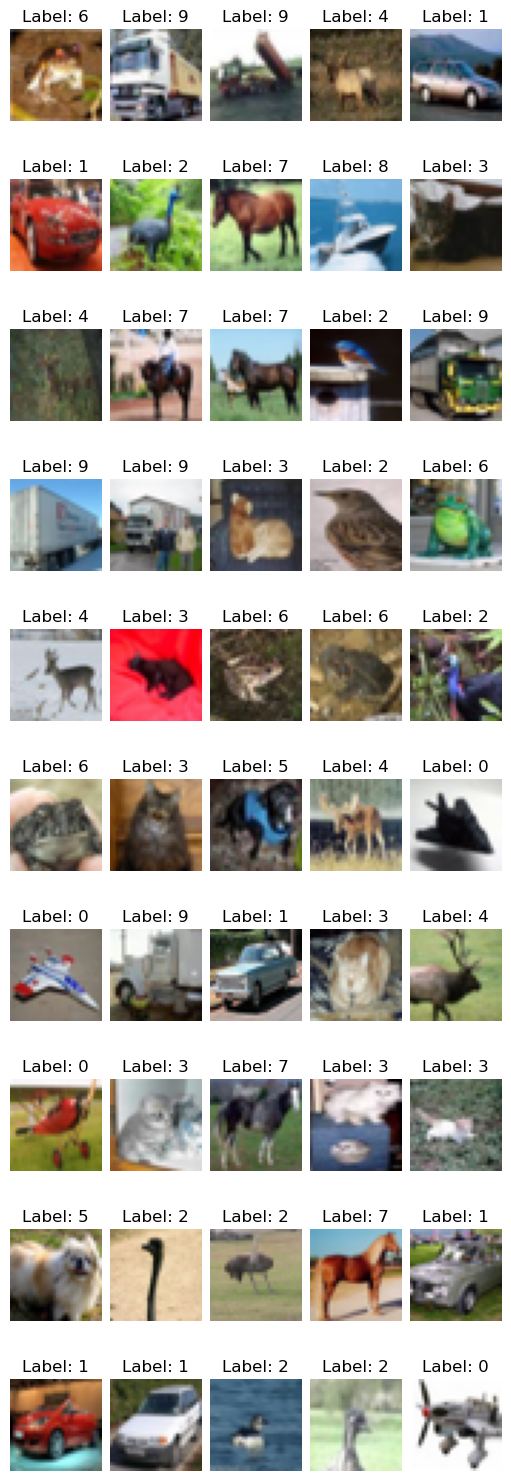

In [9]:
from matplotlib import pyplot as plt

ROW, COL = 10, 5
fig, axes = plt.subplots(ROW, COL, layout="constrained", figsize=(5, 15))
for i in range(ROW):
    for j in range(COL):
        axes[i, j].imshow(X_train[i * COL + j])
        axes[i, j].set_title(f"Label: {y_train[i * COL + j].squeeze()}")
        axes[i, j].axis(False)

## Deep Dense Network with Batch Normalization

In [13]:
from functools import partial

from tensorflow import keras

keras.utils.set_random_seed(42)
HiddenDense = partial(keras.layers.Dense, kernel_initializer="he_normal")

dnn = keras.Sequential(
    [
        (dnorm := keras.layers.Normalization(input_shape=X_train.shape[1:])),
        keras.layers.Flatten(),
    ]
)
for _ in range(20):
    dnn.add(HiddenDense(100))
    dnn.add(keras.layers.BatchNormalization())
    dnn.add(keras.layers.Activation("swish"))
dnn.add(keras.layers.Dense(10, activation="softmax"))

optim_dnn = keras.optimizers.Nadam(learning_rate=5e-5)
dnn.compile(
    optimizer=optim_dnn, loss="sparse_categorical_crossentropy", metrics=["accuracy"]
)

In [14]:
from tensorflow.keras.utils import plot_model

dnn.summary()
plot_model(dnn, to_file=MODEL_DIR / "large_dnn.png")

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_1 (Normaliza  (None, 32, 32, 3)         7         
 tion)                                                           
                                                                 
 flatten_1 (Flatten)         (None, 3072)              0         
                                                                 
 dense_21 (Dense)            (None, 100)               307300    
                                                                 
 batch_normalization_20 (Ba  (None, 100)               400       
 tchNormalization)                                               
                                                                 
 activation_20 (Activation)  (None, 100)               0         
                                                                 
 dense_22 (Dense)            (None, 100)              

FileNotFoundError: [Errno 2] No such file or directory: '/home/twogoodap/Coding_Playground/Machine_Learning/Hands_on_Machine_Learning/handson-machine-learning/handson_ml/chapter_11/models/large_dnn.png'

In [ ]:
%%time

dnorm.adapt(X_train)
history = dnn.fit(
    X_train,
    y_train,
    epochs=100,
    batch_size=128,
    validation_split=0.2,
    callbacks=[
        keras.callbacks.EarlyStopping(
            monitor="val_loss", patience=10, restore_best_weights=True
        ),
        keras.callbacks.ModelCheckpoint(
            str(get_run_dir(MODEL_DIR, name="bn_nadam")),
            monitor="val_loss",
            patience=10,
            save_best_only=True,
        ),
        keras.callbacks.TensorBoard(
            log_dir=str(get_run_dir(LOG_DIR, name="bn_nadam")),
            profile_batch=(100, 200),
        ),
    ],
)

## Self Normalizing Dense Network with Alpha Dropout

In [25]:
from functools import partial

from tensorflow import keras

keras.utils.set_random_seed(42)
LeCunDense = partial(
    keras.layers.Dense, activation="selu", kernel_initializer="lecun_normal"
)

lnn = keras.Sequential(
    [
        (lnorm := keras.layers.Normalization(input_shape=X_train.shape[1:])),
        keras.layers.Flatten(),
    ]
)
for _ in range(20):
    lnn.add(LeCunDense(100))
lnn.add(keras.layers.AlphaDropout(0.2))
lnn.add(keras.layers.Dense(10, activation="softmax"))

optim_lnn = keras.optimizers.Nadam(learning_rate=5e-5)
lnn.compile(
    optimizer=optim_lnn, loss="sparse_categorical_crossentropy", metrics=["accuracy"]
)

In [ ]:
from tensorflow.keras.utils import plot_model

lnn.summary()
plot_model(lnn, to_file=MODEL_DIR / "self_norm_dnn.png")

In [20]:
%%time

epochs = 100
batch_size = 64

lnorm.adapt(X_train)
history = lnn.fit(
    X_train,
    y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_split=0.2,
    callbacks=[
        keras.callbacks.EarlyStopping(
            monitor="val_loss", patience=15, restore_best_weights=True
        ),
        keras.callbacks.ModelCheckpoint(
            str(get_run_dir(MODEL_DIR, name="selu_selective_dropout")),
            monitor="val_loss",
            patience=15,
            save_best_only=True,
        ),
        keras.callbacks.TensorBoard(
            log_dir=str(get_run_dir(LOG_DIR, name="selu_selective_dropout"))
        ),
    ],
)

Epoch 1/100


2023-10-07 10:46:45.493353: I tensorflow/tsl/profiler/lib/profiler_session.cc:104] Profiler session initializing.
2023-10-07 10:46:45.493383: I tensorflow/tsl/profiler/lib/profiler_session.cc:119] Profiler session started.
2023-10-07 10:46:45.493411: I tensorflow/compiler/xla/backends/profiler/gpu/cupti_tracer.cc:1694] Profiler found 1 GPUs
2023-10-07 10:46:45.496955: E tensorflow/compiler/xla/backends/profiler/gpu/cupti_error_manager.cc:137] cuptiGetTimestamp: error 999: 
2023-10-07 10:46:45.496976: E tensorflow/compiler/xla/backends/profiler/gpu/cupti_error_manager.cc:186] cuptiSubscribe: ignored due to a previous error.
2023-10-07 10:46:45.496983: E tensorflow/compiler/xla/backends/profiler/gpu/cupti_error_manager.cc:459] cuptiGetResultString: ignored due to a previous error.
2023-10-07 10:46:45.496988: E tensorflow/compiler/xla/backends/profiler/gpu/cupti_tracer.cc:1746] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error 
202

142/625 [=====>........................] - ETA: 2s - loss: 2.4565 - accuracy: 0.1933

2023-10-07 10:46:49.305058: I tensorflow/tsl/profiler/lib/profiler_session.cc:104] Profiler session initializing.
2023-10-07 10:46:49.305089: I tensorflow/tsl/profiler/lib/profiler_session.cc:119] Profiler session started.
2023-10-07 10:46:49.305099: E tensorflow/compiler/xla/backends/profiler/gpu/cupti_error_manager.cc:135] cuptiGetTimestamp: ignored due to a previous error.
2023-10-07 10:46:49.305103: E tensorflow/compiler/xla/backends/profiler/gpu/cupti_error_manager.cc:186] cuptiSubscribe: ignored due to a previous error.
2023-10-07 10:46:49.305105: E tensorflow/compiler/xla/backends/profiler/gpu/cupti_error_manager.cc:459] cuptiGetResultString: ignored due to a previous error.
2023-10-07 10:46:49.305107: E tensorflow/compiler/xla/backends/profiler/gpu/cupti_tracer.cc:1746] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error 


197/625 [========>.....................] - ETA: 2s - loss: 2.4060 - accuracy: 0.2043

2023-10-07 10:46:49.716000: I tensorflow/tsl/profiler/lib/profiler_session.cc:70] Profiler session collecting data.
2023-10-07 10:46:49.728758: E tensorflow/compiler/xla/backends/profiler/gpu/cupti_error_manager.cc:142] cuptiFinalize: ignored due to a previous error.
2023-10-07 10:46:49.728777: E tensorflow/compiler/xla/backends/profiler/gpu/cupti_error_manager.cc:459] cuptiGetResultString: ignored due to a previous error.
2023-10-07 10:46:49.728781: E tensorflow/compiler/xla/backends/profiler/gpu/cupti_tracer.cc:1837] function cupti_interface_->Finalize()failed with error 
2023-10-07 10:46:49.795725: E tensorflow/compiler/xla/backends/profiler/gpu/cupti_error_manager.cc:135] cuptiGetTimestamp: ignored due to a previous error.
2023-10-07 10:46:49.795752: E tensorflow/compiler/xla/backends/profiler/gpu/cupti_error_manager.cc:135] cuptiGetTimestamp: ignored due to a previous error.
2023-10-07 10:46:49.795759: I tensorflow/compiler/xla/backends/profiler/gpu/cupti_collector.cc:541]  GpuTra

619/625 [============================>.] - ETA: 0s - loss: 2.1900 - accuracy: 0.2581INFO:tensorflow:Assets written to: /home/twogoodap/Coding_Playground/Machine_Learning/Hands_on_Machine_Learning/handson-machine-learning/models/selu_selective_dropout-2023_10_07-10_46_45/assets


INFO:tensorflow:Assets written to: /home/twogoodap/Coding_Playground/Machine_Learning/Hands_on_Machine_Learning/handson-machine-learning/models/selu_selective_dropout-2023_10_07-10_46_45/assets


625/625 [==============================] - 7s 7ms/step - loss: 2.1875 - accuracy: 0.2587 - val_loss: 1.8461 - val_accuracy: 0.3716
Epoch 2/100
620/625 [============================>.] - ETA: 0s - loss: 1.8517 - accuracy: 0.3544INFO:tensorflow:Assets written to: /home/twogoodap/Coding_Playground/Machine_Learning/Hands_on_Machine_Learning/handson-machine-learning/models/selu_selective_dropout-2023_10_07-10_46_45/assets


INFO:tensorflow:Assets written to: /home/twogoodap/Coding_Playground/Machine_Learning/Hands_on_Machine_Learning/handson-machine-learning/models/selu_selective_dropout-2023_10_07-10_46_45/assets


625/625 [==============================] - 4s 6ms/step - loss: 1.8511 - accuracy: 0.3543 - val_loss: 1.7515 - val_accuracy: 0.4073
Epoch 3/100
624/625 [============================>.] - ETA: 0s - loss: 1.6941 - accuracy: 0.4025INFO:tensorflow:Assets written to: /home/twogoodap/Coding_Playground/Machine_Learning/Hands_on_Machine_Learning/handson-machine-learning/models/selu_selective_dropout-2023_10_07-10_46_45/assets


INFO:tensorflow:Assets written to: /home/twogoodap/Coding_Playground/Machine_Learning/Hands_on_Machine_Learning/handson-machine-learning/models/selu_selective_dropout-2023_10_07-10_46_45/assets


625/625 [==============================] - 4s 6ms/step - loss: 1.6941 - accuracy: 0.4025 - val_loss: 1.6823 - val_accuracy: 0.4268
Epoch 4/100
618/625 [============================>.] - ETA: 0s - loss: 1.5965 - accuracy: 0.4388INFO:tensorflow:Assets written to: /home/twogoodap/Coding_Playground/Machine_Learning/Hands_on_Machine_Learning/handson-machine-learning/models/selu_selective_dropout-2023_10_07-10_46_45/assets


INFO:tensorflow:Assets written to: /home/twogoodap/Coding_Playground/Machine_Learning/Hands_on_Machine_Learning/handson-machine-learning/models/selu_selective_dropout-2023_10_07-10_46_45/assets


625/625 [==============================] - 4s 7ms/step - loss: 1.5964 - accuracy: 0.4387 - val_loss: 1.6512 - val_accuracy: 0.4397
Epoch 5/100
625/625 [==============================] - 4s 7ms/step - loss: 1.5268 - accuracy: 0.4586 - val_loss: 1.6593 - val_accuracy: 0.4379
Epoch 6/100
617/625 [============================>.] - ETA: 0s - loss: 1.4706 - accuracy: 0.4820INFO:tensorflow:Assets written to: /home/twogoodap/Coding_Playground/Machine_Learning/Hands_on_Machine_Learning/handson-machine-learning/models/selu_selective_dropout-2023_10_07-10_46_45/assets


INFO:tensorflow:Assets written to: /home/twogoodap/Coding_Playground/Machine_Learning/Hands_on_Machine_Learning/handson-machine-learning/models/selu_selective_dropout-2023_10_07-10_46_45/assets


625/625 [==============================] - 5s 7ms/step - loss: 1.4712 - accuracy: 0.4820 - val_loss: 1.6390 - val_accuracy: 0.4501
Epoch 7/100
625/625 [==============================] - 3s 5ms/step - loss: 1.4230 - accuracy: 0.4935 - val_loss: 1.6581 - val_accuracy: 0.4595
Epoch 8/100
625/625 [==============================] - 3s 4ms/step - loss: 1.3745 - accuracy: 0.5133 - val_loss: 1.6656 - val_accuracy: 0.4637
Epoch 9/100
625/625 [==============================] - 3s 5ms/step - loss: 1.3420 - accuracy: 0.5259 - val_loss: 1.6791 - val_accuracy: 0.4705
Epoch 10/100
625/625 [==============================] - 4s 6ms/step - loss: 1.3033 - accuracy: 0.5383 - val_loss: 1.6945 - val_accuracy: 0.4678
Epoch 11/100
625/625 [==============================] - 3s 5ms/step - loss: 1.2721 - accuracy: 0.5494 - val_loss: 1.6825 - val_accuracy: 0.4735
Epoch 12/100
625/625 [==============================] - 3s 5ms/step - loss: 1.2373 - accuracy: 0.5640 - val_loss: 1.7096 - val_accuracy: 0.4732
Epoch 13

## One Cycle Learning Rate Scheduling for Self-Normalizing DNN

In [15]:
lnorm.adapt(X_train)
lrs, losses = find_learning_rate(lnn, X_train, y_train, max_lr=0.01)

1563/1563 [==============================] - 12s 8ms/step - loss: 2.3087 - accuracy: 0.2067


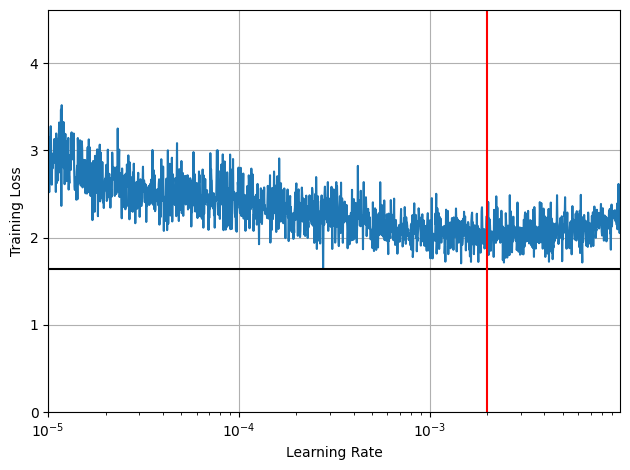

In [17]:
plot_loss_vs_lr(lrs, losses)
plt.gca().vlines(2e-3, 0, 5, "r")

In [26]:
%%time
import math

epochs = 30
batch_size = 256

history = lnn.fit(
    X_train,
    y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_split=0.2,
    callbacks=[
        OneCycleScheduler(
            epochs * math.ceil(0.8 * len(X_train) / batch_size), max_lr=2e-3
        ),
        keras.callbacks.TensorBoard(
            log_dir=str(get_run_dir(LOG_DIR, name="selu_onecycle"))
        ),
    ],
)

Epoch 1/30
  1/157 [..............................] - ETA: 7:39 - loss: 3.2563 - accuracy: 0.0586WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0040s vs `on_train_batch_end` time: 0.0087s). Check your callbacks.


157/157 [==============================] - 4s 6ms/step - loss: 2.2074 - accuracy: 0.2188 - val_loss: 1.9655 - val_accuracy: 0.2901
Epoch 2/30
157/157 [==============================] - 1s 7ms/step - loss: 1.8786 - accuracy: 0.3202 - val_loss: 1.8501 - val_accuracy: 0.3509
Epoch 3/30
157/157 [==============================] - 1s 6ms/step - loss: 1.8036 - accuracy: 0.3515 - val_loss: 1.8261 - val_accuracy: 0.3788
Epoch 4/30
157/157 [==============================] - 1s 8ms/step - loss: 1.7565 - accuracy: 0.3684 - val_loss: 1.7620 - val_accuracy: 0.3898
Epoch 5/30
157/157 [==============================] - 1s 7ms/step - loss: 1.7133 - accuracy: 0.3891 - val_loss: 1.8364 - val_accuracy: 0.3468
Epoch 6/30
157/157 [==============================] - 1s 8ms/step - loss: 1.6863 - accuracy: 0.3940 - val_loss: 1.7920 - val_accuracy: 0.3753
Epoch 7/30
157/157 [==============================] - 1s 7ms/step - loss: 1.6735 - accuracy: 0.4022 - val_loss: 1.7441 - val_accuracy: 0.3982
Epoch 8/30
157/15

## Monte-Carlo Dropout for Self-Normalizing DNN

In [49]:
from tensorflow import keras


class MCAlphaDropout(keras.layers.AlphaDropout):
    def call(self, inputs, training=False):
        return super().call(inputs, training=True)


mc_lnn = keras.Sequential(
    [
        MCAlphaDropout(layer.rate)
        if isinstance(layer, keras.layers.AlphaDropout)
        else layer
        for layer in lnn.layers
    ]
)
mc_lnn.compile(
    optimizer=keras.optimizers.Nadam(learning_rate=5e-5),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)

In [53]:
%%time

epochs = 100
batch_size = 64

(mnorm := mc_lnn.layers[0]).adapt(X_train)
history = mc_lnn.fit(
    X_train,
    y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_split=0.2,
    callbacks=[
        keras.callbacks.EarlyStopping(
            monitor="val_loss", patience=15, restore_best_weights=True
        ),
        keras.callbacks.ModelCheckpoint(
            str(get_run_dir(MODEL_DIR, name="selu_mc_dropout")),
            monitor="val_loss",
            patience=15,
            save_best_only=True,
        ),
        keras.callbacks.TensorBoard(
            log_dir=str(get_run_dir(LOG_DIR, name="selu_mc_dropout"))
        ),
    ],
)

Epoch 1/100
615/625 [============================>.] - ETA: 0s - loss: 1.4598 - accuracy: 0.4795INFO:tensorflow:Assets written to: /home/twogoodap/Coding_Playground/Machine_Learning/Hands_on_Machine_Learning/handson-machine-learning/models/selu_mc_dropout-2023_10_07-13_33_53/assets


INFO:tensorflow:Assets written to: /home/twogoodap/Coding_Playground/Machine_Learning/Hands_on_Machine_Learning/handson-machine-learning/models/selu_mc_dropout-2023_10_07-13_33_53/assets


625/625 [==============================] - 4s 6ms/step - loss: 1.4597 - accuracy: 0.4791 - val_loss: 1.5721 - val_accuracy: 0.4452
Epoch 2/100
618/625 [============================>.] - ETA: 0s - loss: 1.4164 - accuracy: 0.4955INFO:tensorflow:Assets written to: /home/twogoodap/Coding_Playground/Machine_Learning/Hands_on_Machine_Learning/handson-machine-learning/models/selu_mc_dropout-2023_10_07-13_33_53/assets


INFO:tensorflow:Assets written to: /home/twogoodap/Coding_Playground/Machine_Learning/Hands_on_Machine_Learning/handson-machine-learning/models/selu_mc_dropout-2023_10_07-13_33_53/assets


625/625 [==============================] - 3s 5ms/step - loss: 1.4168 - accuracy: 0.4950 - val_loss: 1.5571 - val_accuracy: 0.4570
Epoch 3/100
623/625 [============================>.] - ETA: 0s - loss: 1.3802 - accuracy: 0.5058INFO:tensorflow:Assets written to: /home/twogoodap/Coding_Playground/Machine_Learning/Hands_on_Machine_Learning/handson-machine-learning/models/selu_mc_dropout-2023_10_07-13_33_53/assets


INFO:tensorflow:Assets written to: /home/twogoodap/Coding_Playground/Machine_Learning/Hands_on_Machine_Learning/handson-machine-learning/models/selu_mc_dropout-2023_10_07-13_33_53/assets


625/625 [==============================] - 3s 5ms/step - loss: 1.3800 - accuracy: 0.5058 - val_loss: 1.5568 - val_accuracy: 0.4564
Epoch 4/100
622/625 [============================>.] - ETA: 0s - loss: 1.3498 - accuracy: 0.5166INFO:tensorflow:Assets written to: /home/twogoodap/Coding_Playground/Machine_Learning/Hands_on_Machine_Learning/handson-machine-learning/models/selu_mc_dropout-2023_10_07-13_33_53/assets


INFO:tensorflow:Assets written to: /home/twogoodap/Coding_Playground/Machine_Learning/Hands_on_Machine_Learning/handson-machine-learning/models/selu_mc_dropout-2023_10_07-13_33_53/assets


625/625 [==============================] - 3s 5ms/step - loss: 1.3502 - accuracy: 0.5164 - val_loss: 1.5426 - val_accuracy: 0.4610
Epoch 5/100
625/625 [==============================] - ETA: 0s - loss: 1.3226 - accuracy: 0.5249INFO:tensorflow:Assets written to: /home/twogoodap/Coding_Playground/Machine_Learning/Hands_on_Machine_Learning/handson-machine-learning/models/selu_mc_dropout-2023_10_07-13_33_53/assets


INFO:tensorflow:Assets written to: /home/twogoodap/Coding_Playground/Machine_Learning/Hands_on_Machine_Learning/handson-machine-learning/models/selu_mc_dropout-2023_10_07-13_33_53/assets


625/625 [==============================] - 3s 5ms/step - loss: 1.3226 - accuracy: 0.5249 - val_loss: 1.5400 - val_accuracy: 0.4631
Epoch 6/100
625/625 [==============================] - 3s 4ms/step - loss: 1.2954 - accuracy: 0.5362 - val_loss: 1.5439 - val_accuracy: 0.4655
Epoch 7/100
625/625 [==============================] - 3s 5ms/step - loss: 1.2736 - accuracy: 0.5422 - val_loss: 1.5421 - val_accuracy: 0.4639
Epoch 8/100
625/625 [==============================] - 4s 6ms/step - loss: 1.2492 - accuracy: 0.5520 - val_loss: 1.5571 - val_accuracy: 0.4653
Epoch 9/100
624/625 [============================>.] - ETA: 0s - loss: 1.2275 - accuracy: 0.5578INFO:tensorflow:Assets written to: /home/twogoodap/Coding_Playground/Machine_Learning/Hands_on_Machine_Learning/handson-machine-learning/models/selu_mc_dropout-2023_10_07-13_33_53/assets


INFO:tensorflow:Assets written to: /home/twogoodap/Coding_Playground/Machine_Learning/Hands_on_Machine_Learning/handson-machine-learning/models/selu_mc_dropout-2023_10_07-13_33_53/assets


625/625 [==============================] - 5s 8ms/step - loss: 1.2270 - accuracy: 0.5580 - val_loss: 1.5368 - val_accuracy: 0.4708
Epoch 10/100
625/625 [==============================] - 3s 4ms/step - loss: 1.2071 - accuracy: 0.5660 - val_loss: 1.5592 - val_accuracy: 0.4647
Epoch 11/100
625/625 [==============================] - 4s 7ms/step - loss: 1.1858 - accuracy: 0.5721 - val_loss: 1.5527 - val_accuracy: 0.4695
Epoch 12/100
625/625 [==============================] - 3s 5ms/step - loss: 1.1666 - accuracy: 0.5786 - val_loss: 1.5624 - val_accuracy: 0.4746
Epoch 13/100
625/625 [==============================] - 3s 5ms/step - loss: 1.1495 - accuracy: 0.5864 - val_loss: 1.5783 - val_accuracy: 0.4695
Epoch 14/100
625/625 [==============================] - 4s 6ms/step - loss: 1.1295 - accuracy: 0.5935 - val_loss: 1.5776 - val_accuracy: 0.4747
Epoch 15/100
625/625 [==============================] - 3s 5ms/step - loss: 1.1132 - accuracy: 0.5990 - val_loss: 1.5966 - val_accuracy: 0.4642
Epoch

In [93]:
%%time

n_samples = 20

X_test_norm = mnorm(X_test)
preds = [mc_lnn.predict(X_test_norm) for _ in range(n_samples)]

avg_probas = np.mean(preds, axis=0)
std_probas = np.std(preds, axis=0)

y_pred = np.argmax(avg_probas, axis=1)
print("MC Accuracy:", np.mean(y_test.squeeze() == y_pred))
print("MC stds:", std_probas)

313/313 [==============================] - 0s 802us/step
MC Accuracy: 0.1033
MC stds: [[0.01419282 0.01341765 0.03899764 ... 0.01863501 0.0192649  0.00526601]
 [0.0170223  0.02116652 0.03660156 ... 0.01397478 0.02667426 0.00993182]
 [0.01429806 0.02264566 0.03284738 ... 0.00833924 0.02766087 0.0043785 ]
 ...
 [0.02039137 0.02834161 0.03622834 ... 0.01503465 0.02786741 0.00752094]
 [0.01702811 0.01843499 0.02474604 ... 0.0183882  0.02837063 0.00701299]
 [0.0163828  0.01480979 0.04055008 ... 0.01608844 0.02919684 0.01137651]]
CPU times: user 7.71 s, sys: 285 ms, total: 7.99 s
Wall time: 6.79 s


In [ ]:
import cudf

cudf.DataFrame(history.history)

In [ ]:
X_test_norm = lnorm(X_test)
probs = lnn.predict(X_test_norm)
y_pred = np.argmax(probs, axis=-1).astype("uint8")
y_pred

In [ ]:
import numpy as np

(y_pred == y_test.squeeze()).mean()